# Regression

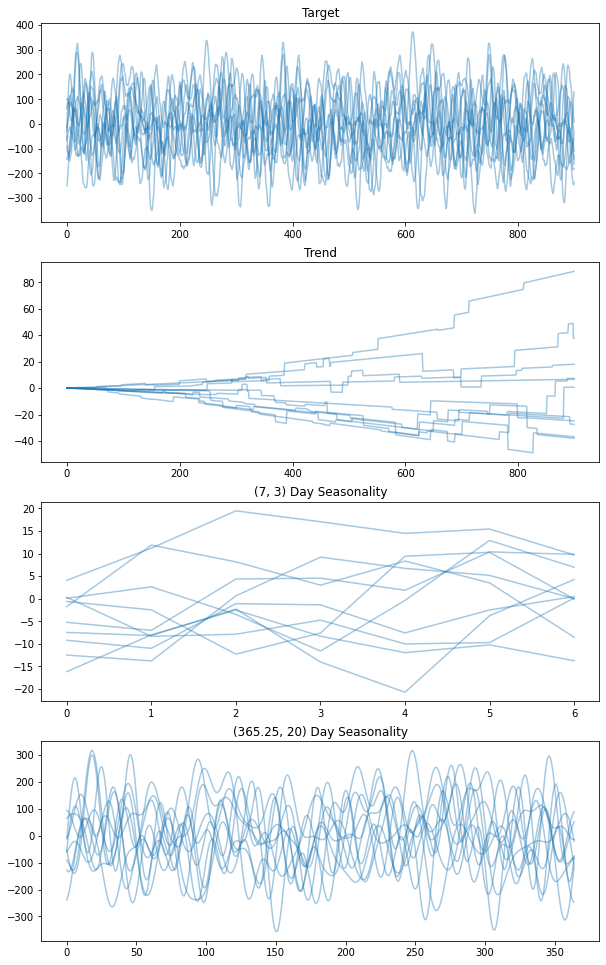

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n_items = 10
n_dates = 900
periods = [
    (7, 3),
    (365.25, 20),
]


def generate_seasonalities(t, n, period, order):
    t = np.arange(t)[None, :]
    N = np.arange(order)[:, None]
    a_n = np.random.normal(size=(n, order))
    b_n = np.random.normal(size=(n, order))
    return (
        a_n.dot(np.sin((2 * np.pi * (N * t)) / period))
        + b_n.dot(np.cos((2 * np.pi * (N * t)) / period))
    )


trends = (
    # intercept
    np.random.normal(size=(n_items, 1))
    + np.cumsum(
        # changepoints
        np.random.normal(size=(n_items, n_dates))
        # mask
        * np.random.choice([0, 1], size=(n_items, n_dates), p=[.98, .02]),
        axis=1)
)
trends *= (np.arange(n_dates)[None, :] / 100)
seasonalities = [
    m * generate_seasonalities(n_dates, n_items, P, order)
    for m, (P, order) in zip((5, 25), periods)
]

y = trends + np.sum(seasonalities, axis=0)

fig, axs = plt.subplots(2 + len(seasonalities), figsize=(10, 10))

axs[0].plot(y.T, color='C0', alpha=.4)
_ = axs[1].plot(trends.T, color='C0', alpha=.4)
for ax, s, (P, _) in zip(axs[2:], seasonalities, periods):
    ax.plot(s[:, :round(P)].T, color='C0', alpha=.4)
    
for ax, title in zip(axs, ['Target', 'Trend', *[f'{day} Day Seasonality' for day in periods]]):
    ax.set_title(title)
    
plt.subplots_adjust(top=1.4)

In [5]:
%run ../ryan_adams/__init__.py
model = RyanAdams(
    trends=LinearTrend(
        n_items=n_items,
        t_range=(0, n_dates)
    ),
    seasonalities=[
        Seasonality(n_items=n_items, period=7, order=3),
        Seasonality(n_items=n_items, period=365.25, order=10),
    ],
    outer_layers=[
        keras.layers.Dense(3, activation='linear'),
        keras.layers.Dense(3, activation='linear'),
    ]
)

2022-08-02 14:03:00.621400: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = pd.DataFrame({
    'id': np.repeat(np.arange(n_items), n_dates),
    't': np.tile(np.arange(n_dates), n_items),
    'y': y.ravel()
})

Xt = X[['id', 't']].to_dict('series')
model._model.fit(
    Xt, X.y,
    batch_size=32,
    epochs=50
)

Epoch 1/50
282/282 [==============================] - 2s 1ms/step - loss: 12900.9941
Epoch 2/50
282/282 [==============================] - 0s 1ms/step - loss: 12602.1797
Epoch 3/50
282/282 [==============================] - 0s 1ms/step - loss: 12196.8291
Epoch 4/50
282/282 [==============================] - 0s 1ms/step - loss: 11367.4248
Epoch 5/50
282/282 [==============================] - 0s 1ms/step - loss: 9760.7207
Epoch 6/50
282/282 [==============================] - 0s 1ms/step - loss: 7948.5698
Epoch 7/50
282/282 [==============================] - 0s 2ms/step - loss: 6965.1890
Epoch 8/50
282/282 [==============================] - 0s 1ms/step - loss: 6660.4722
Epoch 9/50
282/282 [==============================] - 0s 1ms/step - loss: 6578.1987
Epoch 10/50
282/282 [==============================] - 0s 1ms/step - loss: 6559.6216
Epoch 11/50
282/282 [==============================] - 0s 1ms/step - loss: 6524.8887
Epoch 12/50
282/282 [==============================] - 0s 1ms/step - l

In [7]:
model._model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 id (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 linear_trend (LinearTrend)     (None, 1)            220         ['t[0][0]',                      
                                                                  'id[0][0]']                     
                                                                                                  
 seasonality (Seasonality)      (None, 1)            60          ['t[0][0]',                  

In [8]:
X['p'] = model._model.predict(Xt)

<AxesSubplot:>

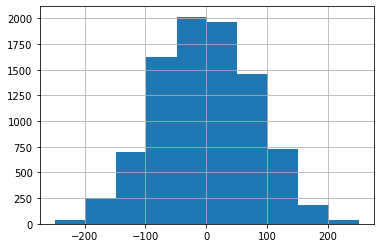

In [9]:
(X.y - X.p).hist()

<AxesSubplot:xlabel='t'>

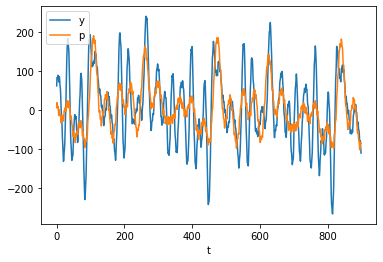

In [10]:
i = np.random.randint(n_items)
X.set_index('id').loc[i].set_index('t')[['y', 'p']].plot()

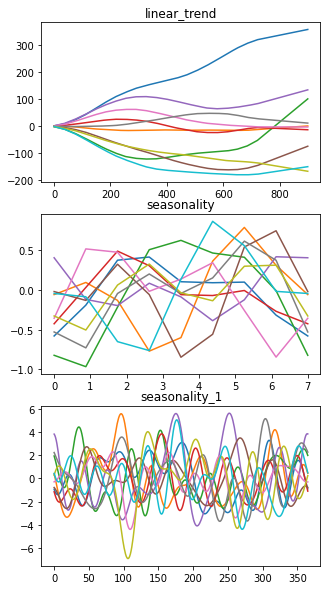

In [12]:
plot_components(model)

# Logistic Growth, Single Series

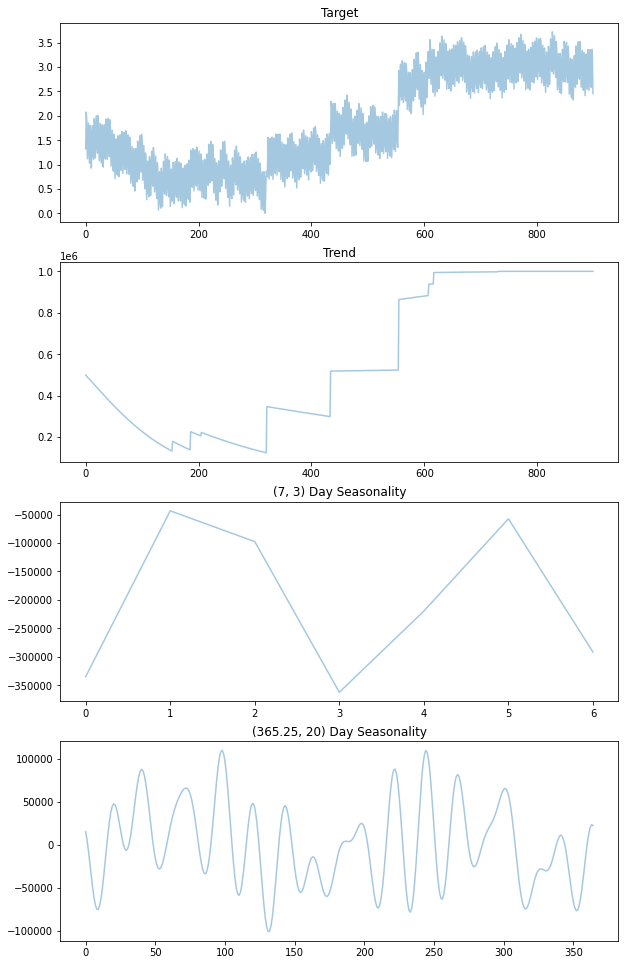

In [13]:
import matplotlib.pyplot as plt
import numpy as np


saturation_point = 1e6
n_items = 1
n_dates = 900
periods = [
    (7, 3),
    (365.25, 20),
]


def generate_seasonalities(t, n, period, order):
    t = np.arange(t)[None, :]
    N = np.arange(order)[:, None]
    a_n = np.random.normal(size=(n, order))
    b_n = np.random.normal(size=(n, order))
    return (
        a_n.dot(np.sin((2 * np.pi * (N * t)) / period))
        + b_n.dot(np.cos((2 * np.pi * (N * t)) / period))
    )


trends = (
    # intercept
    np.random.normal(size=(n_items, 1))
    + np.cumsum(
        # changepoints
        np.abs(np.random.normal(0, .5, size=(n_items, n_dates)))
        # mask
        * np.random.choice([0, 1], size=(n_items, n_dates), p=[.98, .02]),
        axis=1)
)
trends = (saturation_point / ( 1 + np.exp(-trends * (np.arange(n_dates)[None, :] / 100))))
seasonalities = [
    m * generate_seasonalities(n_dates, n_items, P, order)
    for m, (P, order) in zip((saturation_point / 10, saturation_point / 100), periods)
]

y = trends + np.sum(seasonalities, axis=0)
y = (y - y.mean()) / y.std()
y += np.abs(y.min())

fig, axs = plt.subplots(2 + len(seasonalities), figsize=(10, 10))

axs[0].plot(y.T, color='C0', alpha=.4)
_ = axs[1].plot(trends.T, color='C0', alpha=.4)
for ax, s, (P, _) in zip(axs[2:], seasonalities, periods):
    ax.plot(s[:, :round(P)].T, color='C0', alpha=.4)

for ax, title in zip(axs, ['Target', 'Trend', *[f'{day} Day Seasonality' for day in periods]]):
    ax.set_title(title)
    
plt.subplots_adjust(top=1.4)

In [16]:
%run ../ryan_adams/__init__.py
model = RyanAdams(
    trends=SaturatingTrend(
        n_items=n_items,
        t_range=(0, n_dates),
        cap=1,
    ),
    seasonalities=[
        Seasonality(n_items=n_items, period=7, order=3),
        Seasonality(n_items=n_items, period=365.25, order=10),
    ],
    outer_layers=[
        keras.layers.Dense(3, activation='linear'),
        keras.layers.Dense(3, activation='linear'),
    ]
)

In [17]:
X = pd.DataFrame({
    'id': np.repeat(np.arange(n_items), n_dates),
    't': np.tile(np.arange(n_dates), n_items),
    'y': y.ravel()
})

Xt = X[['id', 't']].to_dict('series')
model._model.fit(
    Xt, X.y,
    batch_size=32,
    epochs=50,
)

Epoch 1/50


/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 1s 1ms/step - loss: 0.9340
Epoch 2/50
29/29 [==============================] - 0s 1ms/step - loss: 0.5088
Epoch 3/50
29/29 [==============================] - 0s 1ms/step - loss: 0.2606
Epoch 4/50
29/29 [==============================] - 0s 1ms/step - loss: 0.1586
Epoch 5/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0997
Epoch 6/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 7/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 8/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0372
Epoch 9/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 10/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 11/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 12/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0372
Epoch 13/50
29/29 [==============================] - 0s 1ms/

In [18]:
X['p'] = model._model.predict(Xt)

<AxesSubplot:>

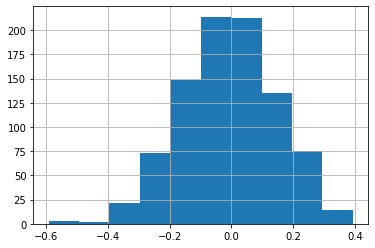

In [19]:
(X.y - X.p).hist()

<AxesSubplot:xlabel='t'>

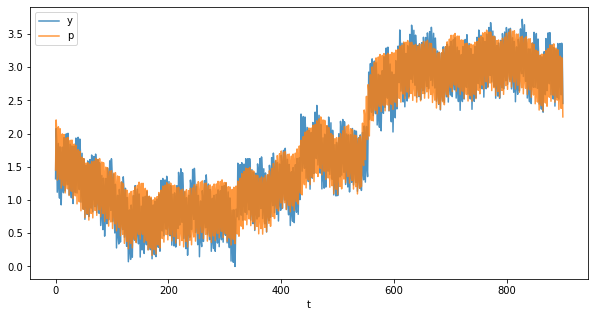

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
i = np.random.randint(n_items)
X.set_index('id').loc[i].set_index('t')[['y', 'p']].plot(alpha=.8, ax=ax)

/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


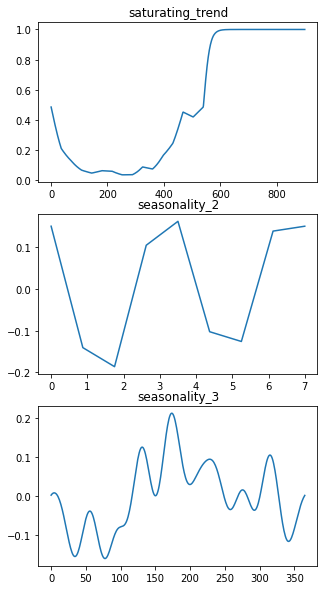

In [22]:
plot_components(model)

# Conversion Rates

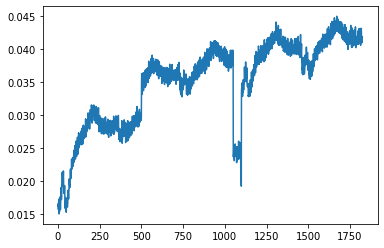

In [23]:
import scipy.stats as ss
import scipy.special as spc


t = np.arange(365 * 5)


def periodic_rbf(x, p, a, m, c):
    return c * np.exp(-.5 * a * ((x % p) - m) ** 2)


product_release = 1 + (t > 500) * .7
table_dropped = 1 - ((t > 1050) & (t < 1100)) * .9

growth = 10 * np.log((t + 90) / 100) * product_release * table_dropped
noise = np.random.normal(size=len(t))

modifier_ix = (t // 365.25).astype(int)
modifier = np.random.normal(size=modifier_ix.max() + 1)
yearly_effect1 = periodic_rbf(t, 365.25, .01, 30, 10) - periodic_rbf(t, 365.25, .001, 33, 15)
yearly_effect1 *= abs(modifier[modifier_ix])

yearly_effect2 = periodic_rbf(t, 365.25, .001, 210, 20) / np.log10(t + 10)

weekly_effect = periodic_rbf(t, 7, 1, 5, 5)


y = growth + yearly_effect1 + yearly_effect2 + weekly_effect + noise
y = .03 * (y - y.min()) / (y.max() - y.min()) + .015

plt.plot(y)

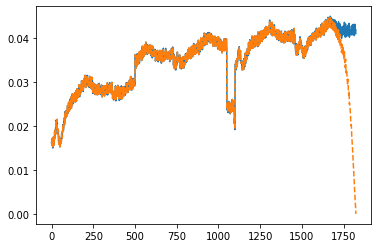

In [24]:
import scipy.stats as ss


time_to_convert = ss.weibull_min(c=1.2, scale=40)

y_observed = y * time_to_convert.cdf(t.max() - t)

plt.plot(y)
plt.plot(y_observed, ls='--')



In [26]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd

def conversion_rate_loss(y_observed, y_θ):
    c, n, t = y_observed[:, 0], y_observed[:, 1], y_observed[:, 2]
    p, k, λ, *p_outlier = y_θ[:, 0], y_θ[:, 1], y_θ[:, 2]#, y_θ[:, 3]
    k = tf.math.sqrt(k)
    p_star = p * tfd.Weibull(k, λ).cdf(t)
    return -tfd.Binomial(total_count=n, probs=p_star).log_prob(c)


%run ../ryan_adams/__init__.py
model = RyanAdams(
    trends=LinearTrend(
        n_items=1,
        t_range=(t.min(), t.max()),
        name='global_trend'
    ),
    seasonalities=[
        Seasonality(n_items=1, period=7, order=3, name='weekly_seasonality'),
        Seasonality(n_items=1, period=365.25, order=10, name='yearly_seasonality'),
    ],
    outer_layers=[
        keras.layers.Dense(5, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(5, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(5, activation='relu'),
    ],
    output_activations=['sigmoid', 'softplus', 'softplus'],
    loss=conversion_rate_loss
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


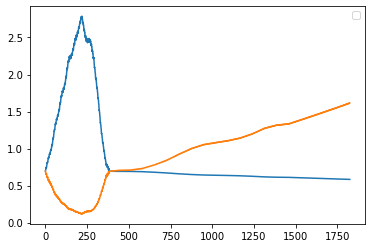

In [27]:
Xt = {'t': t.astype('float') + 1}
yt = np.vstack([
    y_observed * 1e8,
    np.ones_like(t) * 1e8,
    t.max() + 1 - t
]).astype('float32').T

plt.plot(model.predict(Xt)[:, [1, 2]])#, label=['p', 'k', 'θ', 'outlier'])
plt.gca().legend()

In [28]:
initial_predictions = model.predict(Xt)
initial_loss = conversion_rate_loss(yt, initial_predictions)
assert not np.isnan(initial_loss.numpy()).any(), np.isnan(initial_loss.numpy()).mean()

In [29]:
# p, λ, k, p_outlier
initial_predictions.min(axis=0), initial_predictions.max(axis=0)

(array([0.14637527, 0.58300966, 0.11675765], dtype=float32),
 array([0.5020998, 2.7870276, 1.6142942], dtype=float32))

In [30]:
history = model._model.fit(
    Xt, yt,
    batch_size=32,
    epochs=1000,
    verbose=0,
)
history.history['loss'][-1]

7133.298828125

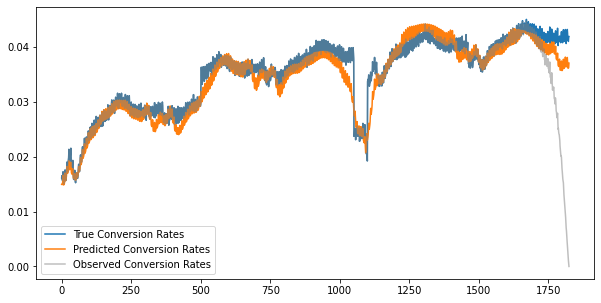

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(y, label='True Conversion Rates')
ax.plot(model.predict(Xt)[:, 0], label='Predicted Conversion Rates')
ax.plot(y_observed, color='C7', label='Observed Conversion Rates', alpha=.5)

ax.legend()

In [32]:
model.plot()

AttributeError: 'RyanAdams' object has no attribute 'plot'